# Image classification for identification of eye diseases using eye disease retinal image dataset.
##### Author
    Md. Mintu Hossain
    ID: 2315034650
    
    This research focusses on classifying retinal eye disease images using different deep learning architectures.
    The objective is to develop a model that can accurately identify various retinal diseases, aiding in early diagnosis treatment.

## 1. Install and Import the required libraries and packages

In [1]:
!pip install tensorflow
!pip install opencv-python
!pip3 install imagehash
!pip install matplotlib seaborn

In [2]:
import os
import time
import shutil
import pathlib
import itertools
import imagehash
from PIL import Image
# import data handling tools
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## 2. Import Data

In [3]:

dataset_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/Eye_Dataset'

image_data = []  # To store images
labels = []      # To store corresponding labels

for class_dir in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, class_dir)):
        class_label = class_dir
        class_path = os.path.join(dataset_path, class_dir)
        for image_filename in os.listdir(class_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(class_path, image_filename)
                image = Image.open(image_path)
                image_data.append(image)
                labels.append(class_label)

## 3. Data Visualization

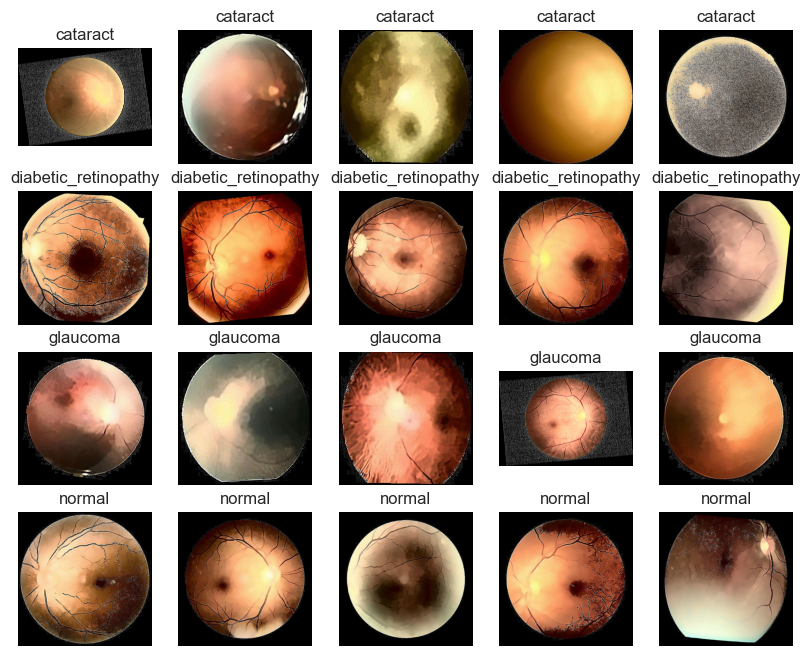

In [17]:

# Path to the directory containing your dataset
##dd = 'path_to_dataset_directory'

# List of subdirectories (representing categories or classes)
categories = sorted(os.listdir(dataset_path))

# Number of sample images to display per category
num_samples = 5

# Create a figure with subplots for each category
fig, axs = plt.subplots(len(categories), num_samples, figsize=(10, 8))

for i, category in enumerate(categories):
    category_dir = os.path.join(dataset_path, category)
    image_files = os.listdir(category_dir)
    
    # Randomly select a few sample images
    sample_images = random.sample(image_files, num_samples)
    
    for j, image_file in enumerate(sample_images):
        image_path = os.path.join(category_dir, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        
        axs[i, j].imshow(img)
        axs[i, j].set_title(category)
        axs[i, j].axis('off')

plt.show()

## 4. Data Splitting

In [18]:
import random

# Set your dataset path
dataset_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/Eye_Dataset'

# Define paths for your training, validation, and test sets
train_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/training_data'
valid_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/validation_data'
test_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/testing_data'

# Define the ratio for splitting (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Create directories for the training, validation, and test sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(valid_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate through the classes in your dataset
for class_dir in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, class_dir)):
        class_images = os.listdir(os.path.join(dataset_path, class_dir))
        random.shuffle(class_images)  # Shuffle the images in each class

        # Split the images into training, validation, and test sets
        num_images = len(class_images)
        num_train = int(train_ratio * num_images)
        num_valid = int(valid_ratio * num_images)

        train_images = class_images[:num_train]
        valid_images = class_images[num_train:num_train + num_valid]
        test_images = class_images[num_train + num_valid:]

        # Copy images to the corresponding directories
        for image in train_images:
            src = os.path.join(dataset_path, class_dir, image)
            dest = os.path.join(train_path, class_dir, image)
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(src, dest)

        for image in valid_images:
            src = os.path.join(dataset_path, class_dir, image)
            dest = os.path.join(valid_path, class_dir, image)
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(src, dest)

        for image in test_images:
            src = os.path.join(dataset_path, class_dir, image)
            dest = os.path.join(test_path, class_dir, image)
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(src, dest)

## 5. Data Partitioning (Training & Testing)

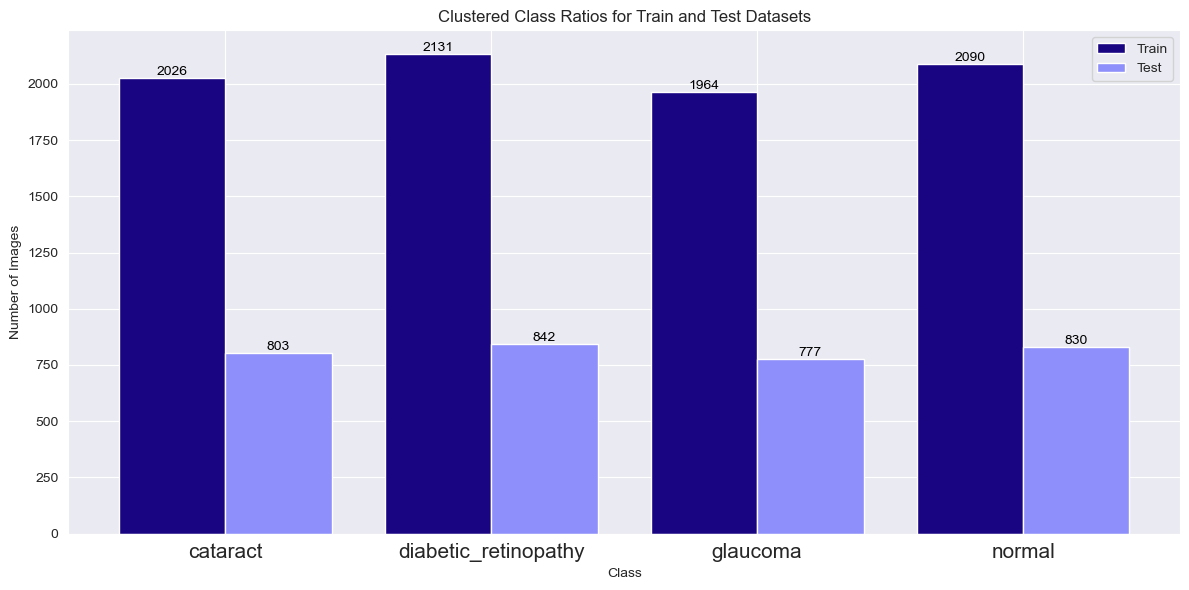

In [4]:
# Define the paths to your train and test datasets

train_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/training_data'
valid_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/validation_data'
test_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/testing_data'

# Initialize dictionaries to store class counts for train and test
train_class_counts = {}
test_class_counts = {}

# Count the number of images for each class in the train dataset
for class_dir in os.scandir(train_dir):
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len([entry.name for entry in os.scandir(class_dir) if entry.is_file()])
        train_class_counts[class_name] = image_count

# Count the number of images for each class in the test dataset
for class_dir in os.scandir(test_dir):
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len([entry.name for entry in os.scandir(class_dir) if entry.is_file()])
        test_class_counts[class_name] = image_count

# Extract class names and counts for plotting
train_class_names = list(train_class_counts.keys())
train_image_counts = list(train_class_counts.values())

test_class_names = list(test_class_counts.keys())
test_image_counts = list(test_class_counts.values())

# Combine the train and test data for plotting
all_class_names = train_class_names
train_image_counts = np.array(train_image_counts)
test_image_counts = np.array(test_image_counts)

x = np.arange(len(all_class_names))
width = 0.40

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_image_counts, width, label='Train', color='#190482')
plt.bar(x + width/2, test_image_counts, width, label='Test', color='#8E8FFA')
plt.title('Clustered Class Ratios for Train and Test Datasets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend()
plt.xticks(x, all_class_names, rotation=0, fontsize=15, ha="center")

# Add count labels on top of the bars
for i, count in enumerate(train_image_counts):
    plt.text(x[i] - width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
for i, count in enumerate(test_image_counts):
    plt.text(x[i] + width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## 6. InceptionV3 Model Train

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set your dataset paths and parameters
train_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/training_data'
valid_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/validation_data'
test_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/testing_data'
batch_size = 32
image_size = (299, 299)  # InceptionV3 expects 299x299 images
num_classes = 4  # Set the number of classes in your dataset

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8211 images belonging to 4 classes.
Found 3255 images belonging to 4 classes.
Found 3252 images belonging to 4 classes.


In [6]:
# Create the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 15  # Set the number of training epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/15
256/256 [==============================] - 1068s 4s/step - loss: 0.6796 - accuracy: 0.7280 - val_loss: 0.5741 - val_accuracy: 0.7840
Epoch 2/15
256/256 [==============================] - 1067s 4s/step - loss: 0.5412 - accuracy: 0.7934 - val_loss: 0.5011 - val_accuracy: 0.8088
Epoch 3/15
256/256 [==============================] - 1055s 4s/step - loss: 0.4925 - accuracy: 0.8074 - val_loss: 0.4592 - val_accuracy: 0.8277
Epoch 4/15
256/256 [==============================] - 1064s 4s/step - loss: 0.4561 - accuracy: 0.8250 - val_loss: 0.4456 - val_accuracy: 0.8283
Epoch 5/15
256/256 [==============================] - 1077s 4s/step - loss: 0.4347 - accuracy: 0.8297 - val_loss: 0.5003 - val_accuracy: 0.8045
Epoch 6/15
256/256 [==============================] - 1063s 4s/step - loss: 0.4202 - accuracy: 0.8357 - val_loss: 0.4188 - val_accuracy: 0.8475
Epoch 7/15
256/256 [==============================] - 1067s 4s/step - loss: 0.4157 - accuracy: 0.8346 - val_loss: 0.4013 - val_accuracy:

## 7. Validation Loss

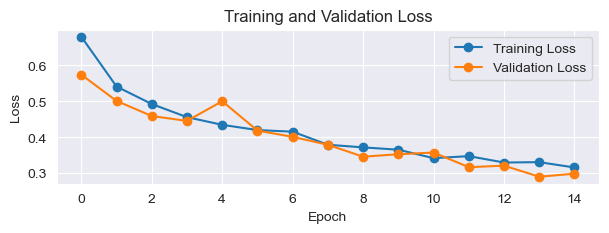

In [7]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have access to the training history
# The training history is typically returned by the `model.fit` method

# Access the training history
# history = model.fit()  # Replace with your actual model.fit() call

# Plot training and validation loss
plt.figure(figsize=(7, 2))
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. Validation Accuarcy

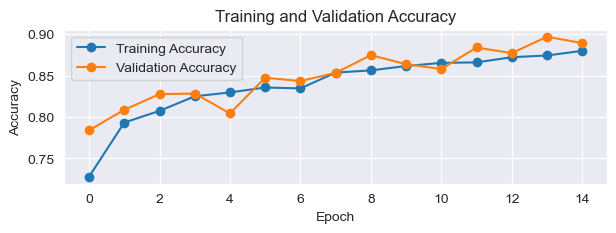

In [8]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have access to the training history
# The training history is typically returned by the `model.fit` method

# Access the training history
#history = model.fit()  # Replace with your actual model.fit() call

# Plot training and validation accuracy
plt.figure(figsize=(7, 2))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 9. Model Performance Evaluation

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have already trained your VGG model and you have the test data in a directory
test_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/Preprocessed_Eye_Dataset/testing_data'
batch_size = 32  # Adjust the batch size as needed

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Adjust to match your model's input size
    batch_size=batch_size,
    class_mode='categorical',  # Change if using different class modes
    shuffle=False  # Set to False to maintain order for confusion matrix
)

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert one-hot encoded labels to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Generate a confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion)

Found 3252 images belonging to 4 classes.
102/102 [==============================] - 162s 2s/step
Accuracy: 0.68
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.92      0.75      0.83       803
diabetic_retinopathy       0.80      0.76      0.78       842
            glaucoma       0.49      0.89      0.63       777
              normal       0.76      0.34      0.47       830

            accuracy                           0.68      3252
           macro avg       0.74      0.69      0.68      3252
        weighted avg       0.75      0.68      0.68      3252

Confusion Matrix:
[[604   4 176  19]
 [  2 641 145  54]
 [ 42  23 695  17]
 [  8 130 407 285]]


## 10. Confusion Matrix

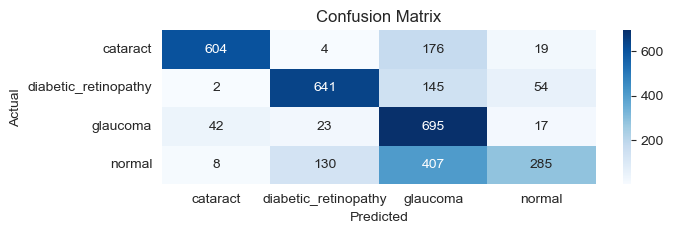

In [10]:
plt.figure(figsize=(7, 2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 11. ROC Curve

ROC AUC score: 0.9054398100869078


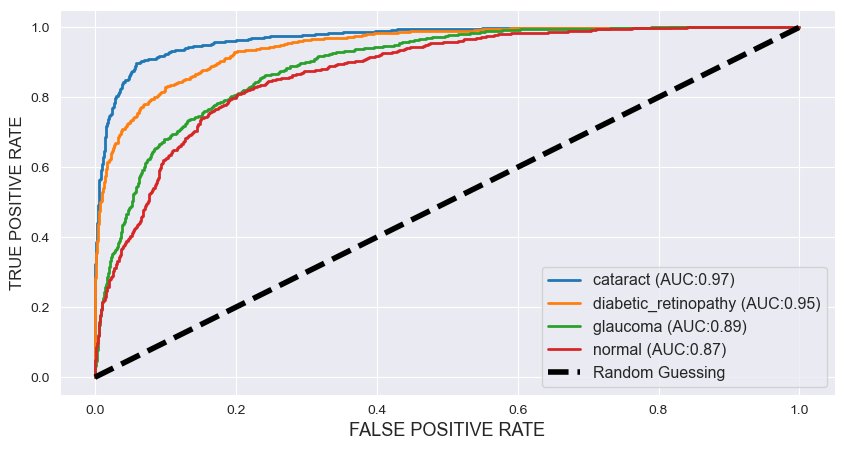

In [11]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# preds = model.predict(test_generator)
preds = predictions
# y_test = test_generator.classes
y_test = true_classes
fig, c_ax = plt.subplots(1,1, figsize = (10,5))
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=13)
plt.ylabel('TRUE POSITIVE RATE', fontsize=12)
plt.legend(fontsize = 11.5)
plt.show()